In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# Graph configuration
%matplotlib inline
def set_graph_style():
    
    # Seaborn base style
    sns.set(
        style="darkgrid",
        context="talk",
        palette="Set2"
    )

    # Matplotlib settings
    plt.rcParams.update({
        # Lines and borders
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 1,
        'grid.linewidth': 1,
        
        # Colors and grid
        'axes.edgecolor': 'black',
        'grid.color': 'black',
        'grid.alpha': .1,
        'patch.edgecolor': 'black',
        
        # Text and labels
        'text.color': 'black',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'font.size': 12,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Arial', 'Liberation Sans'],

        # Tick sizes
        'xtick.major.size': 5,
        'ytick.major.size': 5,
    })

set_graph_style()


The dataset used in this project comes from the Kaggle repository **"Cloud Infrastructure Anomaly Detection Data"**, published by Sandhya Peesara (latest version 2025). The dataset contains operational behavior records from multiple virtual machines with a label named **"Anomaly status"** that classifies records as:

- **0 → Normal**
- **1 → Anomalous**

Therefore, this is a **supervised classification** problem: the goal is to train models to **predict whether a VM's state is normal or anomalous** using its performance metrics as predictors.

#### About the Dataset

The dataset file is `Cloud_Anomaly_Dataset.csv`. It contains operational measurements at different time points for multiple VMs. The dataset variables include:

| Variable | Type | Description |
|--------|------|-------------|
| `vm_id` | Categorical | Unique identifier for the virtual machine. |
| `timestamp` | Time | Timestamp of the metrics record. |
| `cpu_usage` | Numeric (%) | CPU usage percentage. |
| `memory_usage` | Numeric (%) | RAM usage percentage. |
| `network_traffic` | Numeric (bytes/s) | Network traffic. |
| `power_consumption` | Numeric (W) | Power consumption. |
| `num_executed_instructions` | Numeric | Number of executed instructions. |
| `execution_time` | Numeric (s) | Execution time of the task. |
| `energy_efficiency` | Numeric | Ratio between work and energy consumed. |
| `task_type` | Categorical | Task type (`compute`, `network`, `io`, etc.). |
| `task_priority` | Categorical | Task priority (`low`, `medium`, `high`). |
| `task_status` | Categorical | Execution status (`running`, `completed`, etc.). |
| **`Anomaly status`** | Binary (0/1) | Target label for the model. |

*Preliminary observations:*

- There are some missing values across several columns; we need to decide appropriate preprocessing techniques before training models.
- The dataset appears heavily imbalanced, with many more records labeled as **normal (0)** than **anomalous (1)**.

In [4]:
# load dataset
df = pd.read_csv("dataset/Cloud_Anomaly_Dataset.csv")

df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status,Anomaly status
0,c5215826-6237-4a33-9312-72c1df909881,25-01-2023 09:10,54.881350,78.950861,164.775973,287.808986,7527.0,69.345575,0.553589,network,medium,waiting,0
1,29690bc6-1f34-403b-b509-a1ecb1834fb8,26-01-2023 04:46,71.518937,29.901883,NaN,362.273569,5348.0,41.396040,0.349856,io,high,completed,0
2,2e55abc3-5bad-46cb-b445-a577f5e9bf2a,13-01-2023 23:39,NaN,92.709195,203.674847,231.467903,5483.0,24.602549,0.796277,io,medium,completed,0
3,ea8455b0-251c-4470-b7ea-8d40476e3434,14-01-2023 19:59,79.172504,2.972252,926.374030,173.559325,8644.0,55.702673,0.779499,compute,medium,completed,0
4,fd28310b-be6f-4320-a664-de02274993d9,18-01-2023 11:22,87.001215,46.620176,437.188115,77.054702,9427.0,NaN,0.207164,NaN,low,waiting,0


From the initial dataset records, we can observe the following characteristics of the data:

- **`vm_id`** acts as a unique identifier for the virtual machine from which each record originates and appears to follow a UUID format.
- A **`timestamp`** column provides temporal information, which will be analyzed to determine whether specific time periods are associated with a higher occurrence of anomalies.
- **Numerical predictor variables** include `cpu_usage`, `memory_usage`, `network_traffic`, `power_consumption`, `num_executed_instructions`, `execution_time`, and `energy_efficiency`. These variables contain continuous (floating-point) values and will require scaling in subsequent preprocessing steps.
- **Categorical predictor variables** include `task_type`, `task_priority`, and `task_status`. These variables will be transformed into numerical representations through appropriate encoding techniques, depending on whether they exhibit nominal or ordinal characteristics.
- The dataset exhibits **data quality issues**, such as missing values in one or more variables, which will be examined through reports and visualizations and addressed using suitable correction and imputation strategies.
- The **target variable**, `Anomaly status`, is binary, where `0` represents normal virtual machine performance and `1` indicates anomalous behavior.


In [5]:
# Generar informe de los datos
print(df.info())

<class 'pandas.DataFrame'>
RangeIndex: 277570 entries, 0 to 277569
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   vm_id                      249595 non-null  str    
 1   timestamp                  277570 non-null  str    
 2   cpu_usage                  250130 non-null  float64
 3   memory_usage               249775 non-null  float64
 4   network_traffic            249725 non-null  float64
 5   power_consumption          250018 non-null  float64
 6   num_executed_instructions  249637 non-null  float64
 7   execution_time             249960 non-null  float64
 8   energy_efficiency          249616 non-null  float64
 9   task_type                  249580 non-null  str    
 10  task_priority              249674 non-null  str    
 11  task_status                249621 non-null  str    
 12  Anomaly status             277570 non-null  int64  
dtypes: float64(7), int64(1), str(5)
memory u

The dataset consists of **277,570 records** and **13 columns**, making it suitable for supervised learning tasks. It includes:

- **Numerical variables (7):** `cpu_usage`, `memory_usage`, `network_traffic`, `power_consumption`, `num_executed_instructions`, `execution_time`, `energy_efficiency`.
- **Categorical variables (4):** `task_type`, `task_priority`, `task_status`, `vm_id`.
- **Temporal variable (1):** `timestamp`.
- **Target variable (1):** `Anomaly status`.

Several columns contain missing values, particularly those related to operational metrics and task attributes (e.g., `vm_id`, `memory_usage`, `network_traffic`, `num_executed_instructions`, `task_status`). This necessitates the application of appropriate data imputation techniques during preprocessing.

The `timestamp` column is stored as text and must be converted to `datetime` format to enable temporal feature extraction. The target variable, `Anomaly status`, contains no missing values and is of integer type, confirming that the problem is a binary classification task.

At this stage, data preparation requires handling missing values, encoding categorical variables according to their nominal or ordinal nature, and converting and evaluating temporal features for modeling relevance.


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cpu_usage,250130.0,50.013258,28.895806,0.000071,24.880023,50.023806,75.097896,99.999171
memory_usage,249775.0,49.967249,28.879090,0.000016,24.965105,49.912051,74.960052,99.999907
network_traffic,249725.0,500.554083,288.787794,0.002542,250.298114,500.736963,750.720026,999.998686
power_consumption,250018.0,249.987238,144.662676,0.000802,124.199907,250.397212,375.485305,499.998819
num_executed_instructions,249637.0,5002.490284,2882.806422,0.000000,2506.000000,5000.000000,7499.000000,9999.000000
execution_time,249960.0,50.011964,28.837634,0.000172,25.098016,50.005593,75.043715,99.998831
energy_efficiency,249616.0,0.500369,0.288547,0.000004,0.250375,0.500834,0.750112,0.999994
Anomaly status,277570.0,0.059999,0.237486,0.000000,0.000000,0.000000,0.000000,1.000000


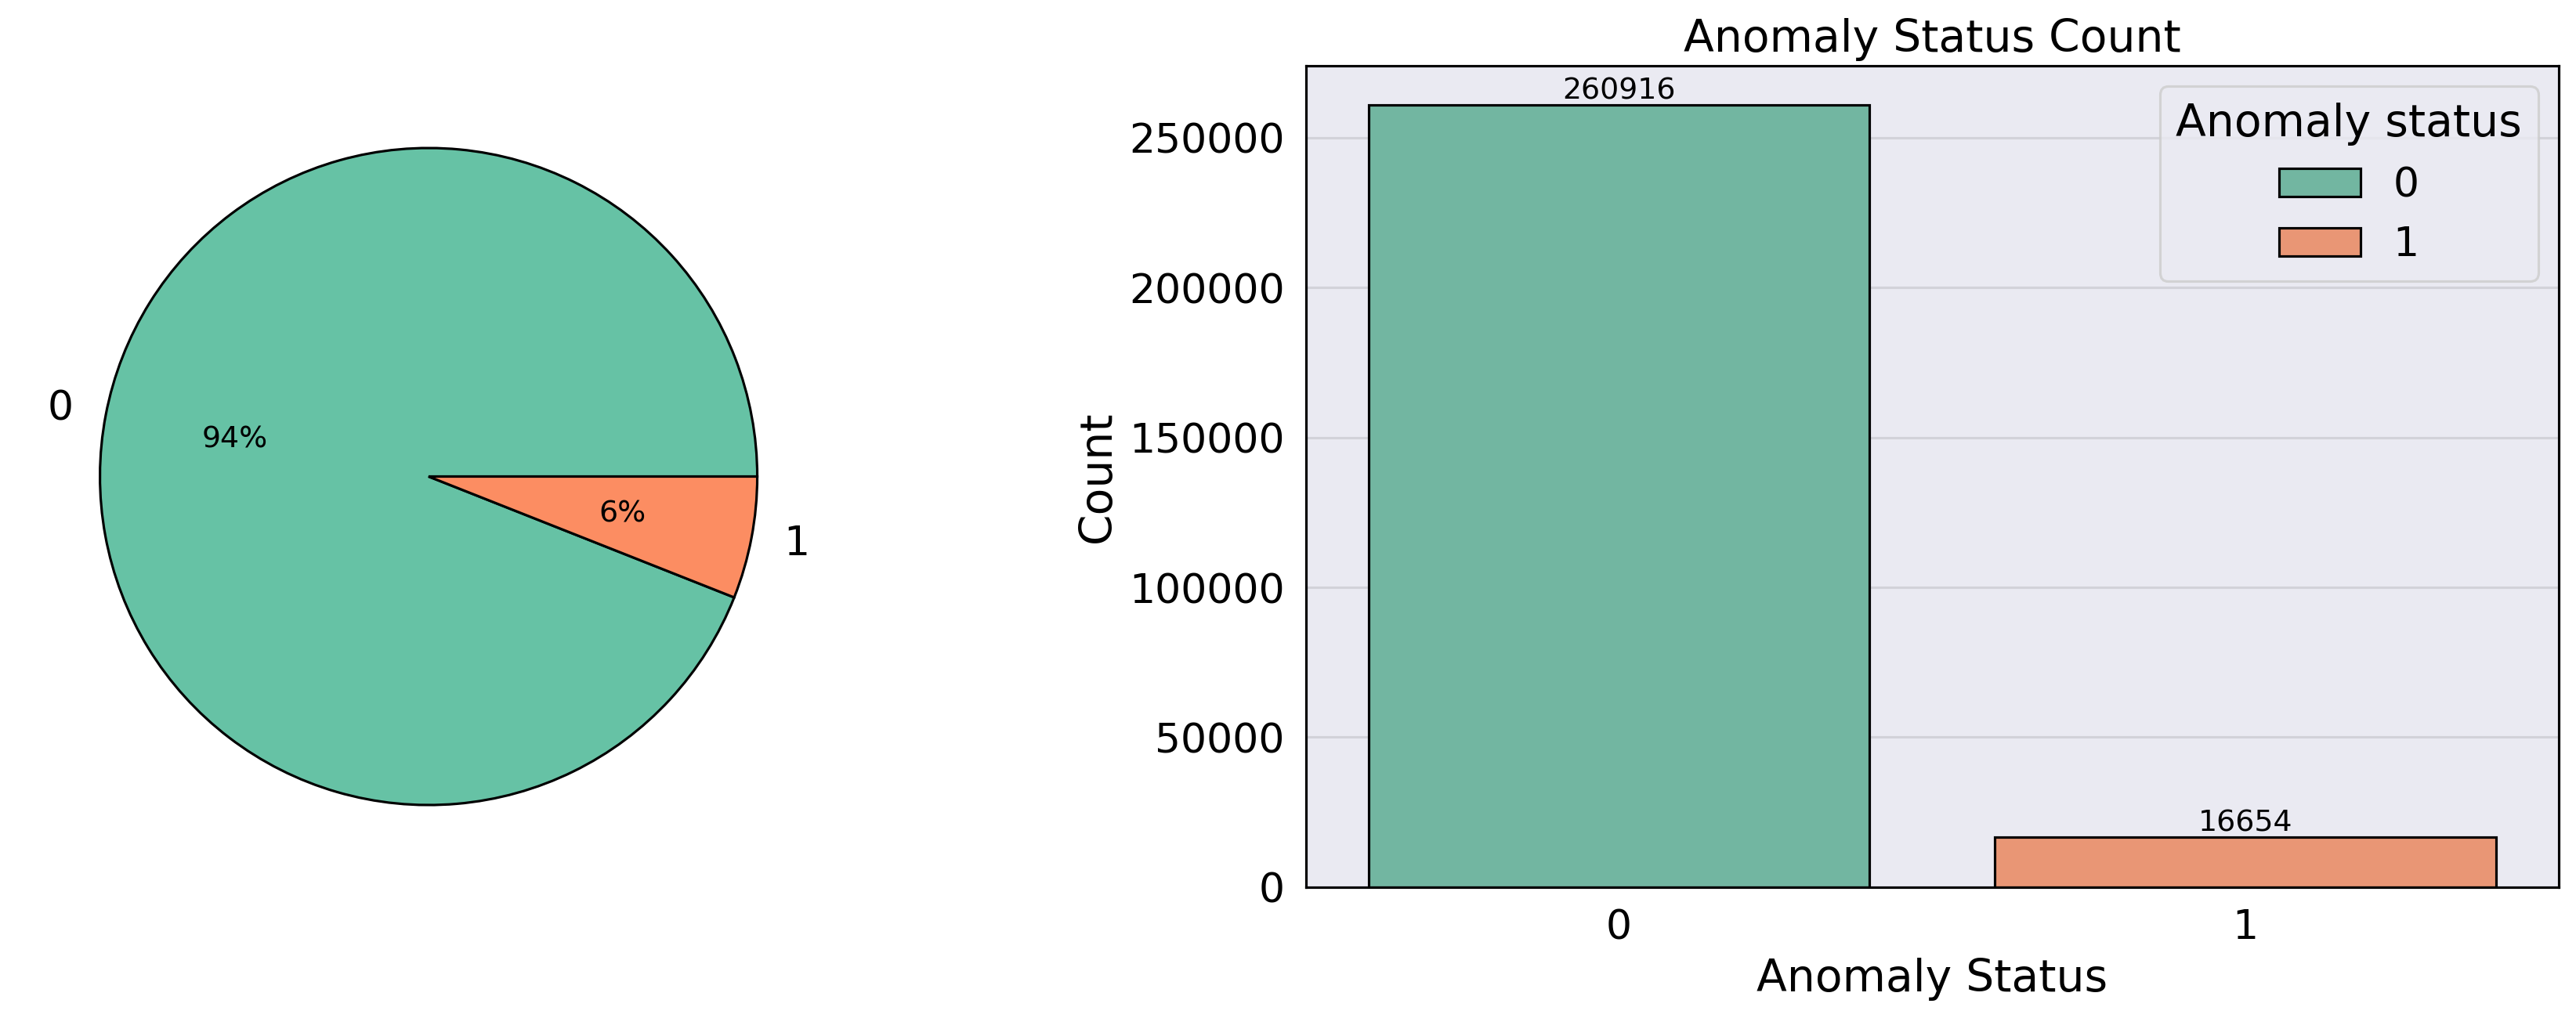

In [7]:
# Histogram and pie chart of the class attribute
labels = df['Anomaly status'].unique()
dist = (df['Anomaly status'].value_counts()).to_numpy()

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(dist, labels=labels, autopct='%1.0f%%')

plt.subplot(1, 2, 2)
ax = sns.countplot(x='Anomaly status', hue='Anomaly status', data=df)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Anomaly Status')
plt.ylabel('Count')
plt.title("Anomaly Status Count")
plt.show()


The dataset is highly imbalanced. Approximately **94%** of the records correspond to normal system behavior (0), while only **6%** represent anomalous events (1).

This distribution is expected in real-world cloud infrastructure environments, where anomalous events occur far less frequently than normal operations.


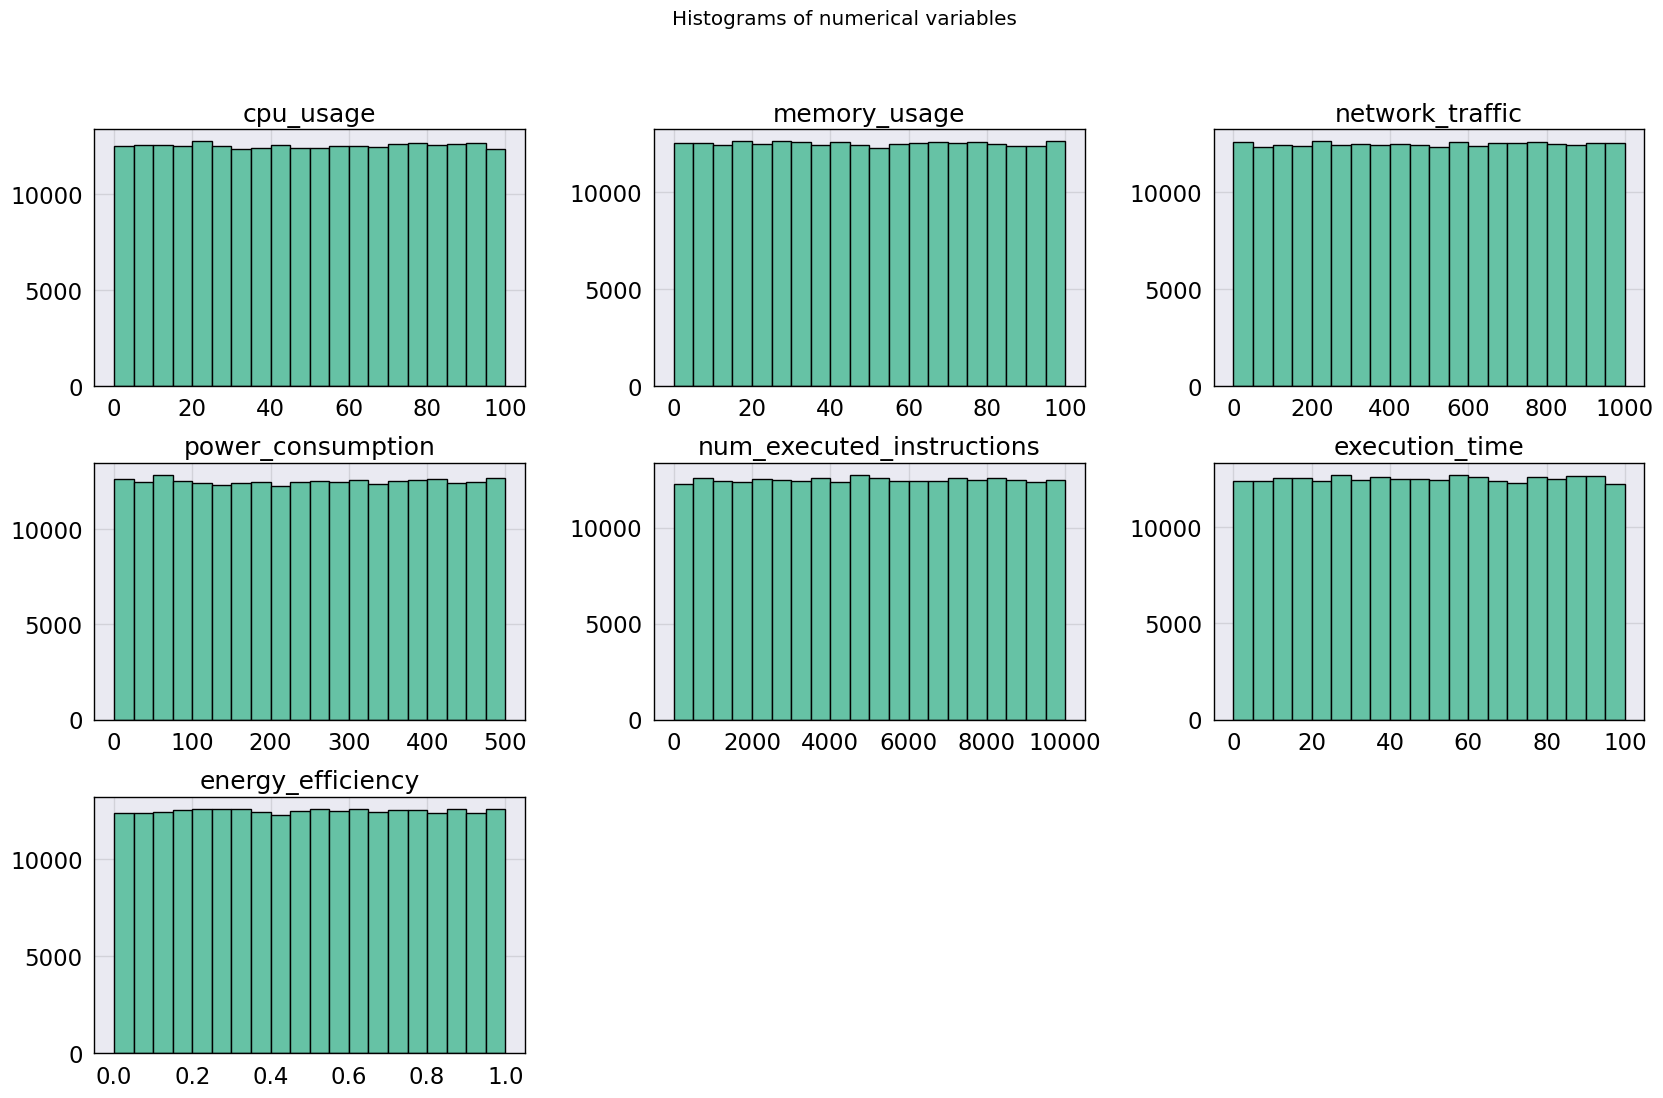

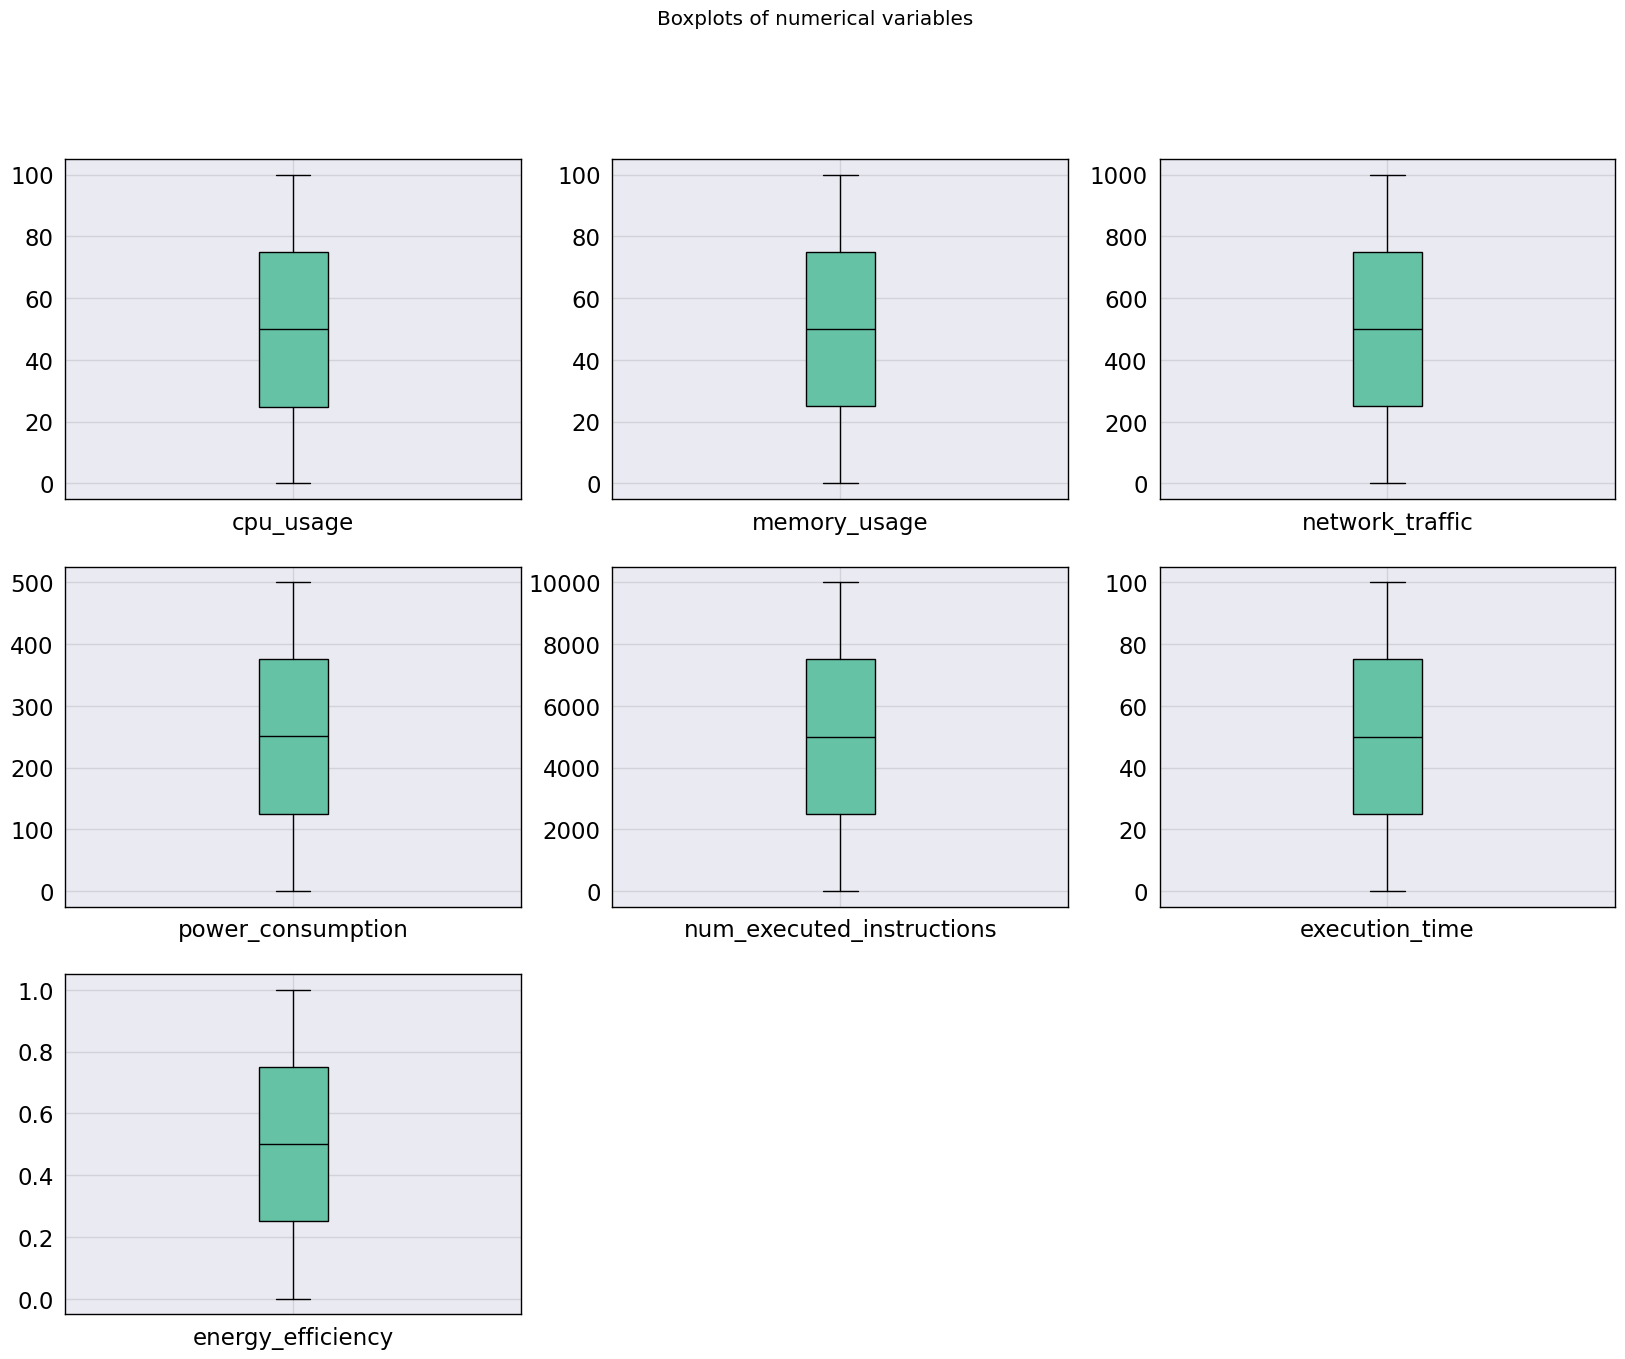

In [8]:
# Histograms for each numerical variable
numerical_predictors = (
    df.dropna()
      .drop(['Anomaly status'], axis=1)
      .select_dtypes(include=['int64', 'float64'])
      .columns
      .tolist()
)

df[numerical_predictors].hist(figsize=(20, 12), bins=20)
plt.suptitle("Histograms of numerical variables")
plt.show()

# Boxplot for each numerical variable
df[numerical_predictors].plot.box(
    subplots=True, 
    layout=(3, 3),
    figsize=(20, 15),
    sharey=False,
    title="Boxplots of numerical variables",
    patch_artist=True,
    boxprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    medianprops=dict(color="black"),
)
plt.show()


By analyzing the histogram and boxplot visualizations of the numerical variables, we observe an approximately uniform distribution across all system metrics, including CPU usage, memory usage, network traffic, power consumption, execution time, energy efficiency, and the number of executed instructions.

## Missing Values Inspection

Summary of missing and non-missing values by 'Anomaly status' class:


Class 0 (Normal):
                           Non-missing values  Missing values  Total records
vm_id                                  234646           26270         260916
timestamp                              260916               0         260916
cpu_usage                              235836           25080         260916
memory_usage                           234719           26197         260916
network_traffic                        234680           26236         260916
power_consumption                      234986           25930         260916
num_executed_instructions              234641           26275         260916
execution_time                         235745           25171         260916
energy_efficiency                      233528           27388         260916
task_type                              234674           26242         260916
task_priority                          234702           26214   

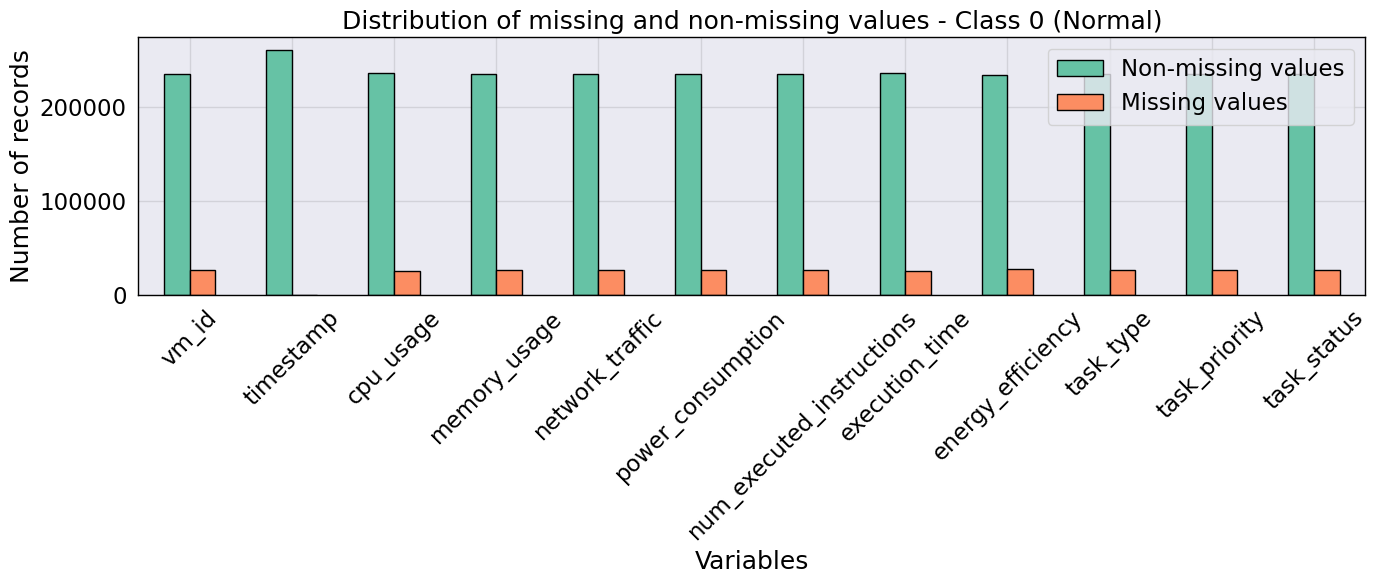


Class 1 (Anomalous):
                           Non-missing values  Missing values  Total records
vm_id                                   14949            1705          16654
timestamp                               16654               0          16654
cpu_usage                               14294            2360          16654
memory_usage                            15056            1598          16654
network_traffic                         15045            1609          16654
power_consumption                       15032            1622          16654
num_executed_instructions               14996            1658          16654
execution_time                          14215            2439          16654
energy_efficiency                       16088             566          16654
task_type                               14906            1748          16654
task_priority                           14972            1682          16654
task_status                             15183         

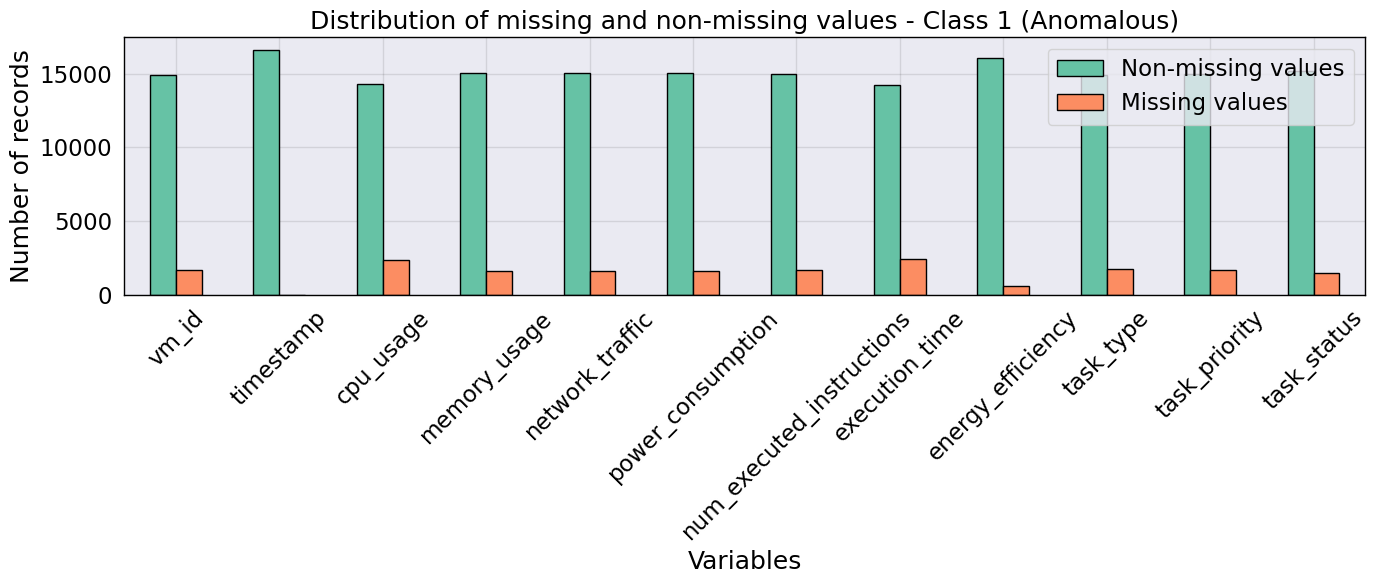

In [9]:
# For each class, missing values are counted
missing_stats = df.groupby('Anomaly status').apply(
    lambda x: pd.DataFrame({
        'Non-missing values': x.notna().sum(),
        'Missing values': x.isna().sum(),
        'Total records': len(x)
    }),
    include_groups=False
)

print("Summary of missing and non-missing values by 'Anomaly status' class:\n")

for status in df['Anomaly status'].unique():
    print(f"\nClass {status} ({'Normal' if status == 0 else 'Anomalous'}):")
    subset = missing_stats.loc[status]
    try:
        print(subset.to_markdown(tablefmt="github"))
    except:
        print(subset.to_string(index=True))
    
    subset[['Non-missing values', 'Missing values']].plot(
        kind='bar', figsize=(14, 6),
        title=f"Distribution of missing and non-missing values - Class {status} ({'Normal' if status == 0 else 'Anomalous'})"
    )
    # The result is plotted per class
    plt.xlabel("Variables")
    plt.ylabel("Number of records")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Global summary of missing values by variable:

                           Missing values  Non-missing values  Total records  Missing percentage (%)
task_type                           27990              249580         277570                   10.08
vm_id                               27975              249595         277570                   10.08
energy_efficiency                   27954              249616         277570                   10.07
task_status                         27949              249621         277570                   10.07
num_executed_instructions           27933              249637         277570                   10.06
task_priority                       27896              249674         277570                   10.05
network_traffic                     27845              249725         277570                   10.03
memory_usage                        27795              249775         277570                   10.01
execution_time                      27610  

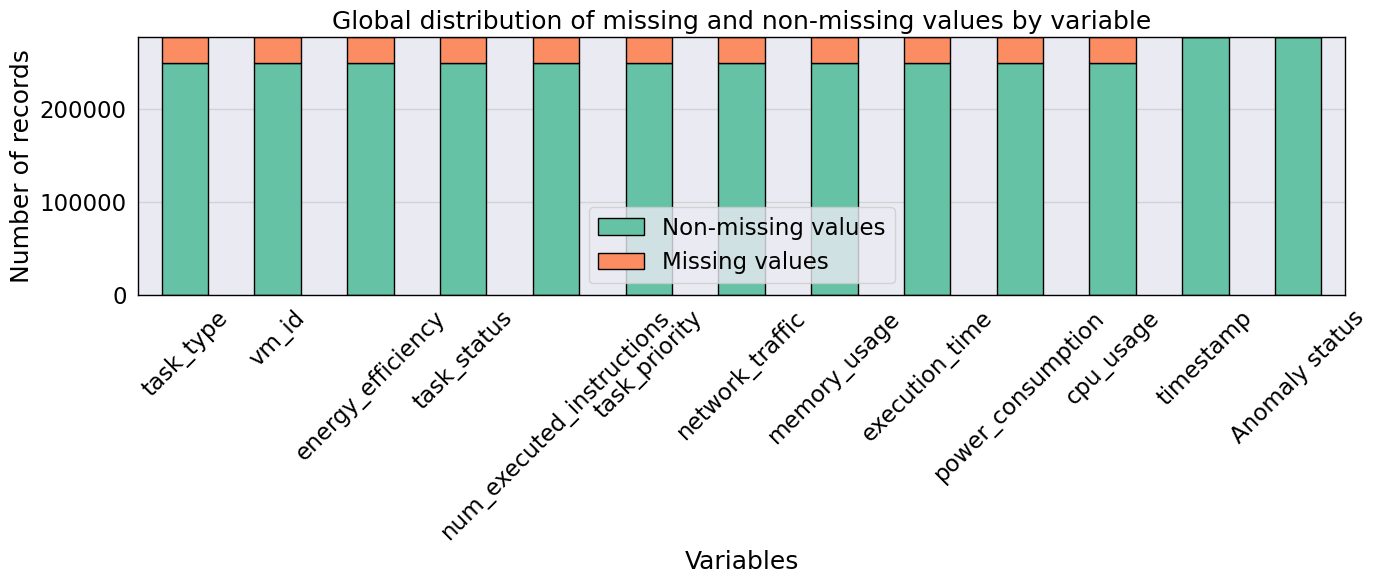

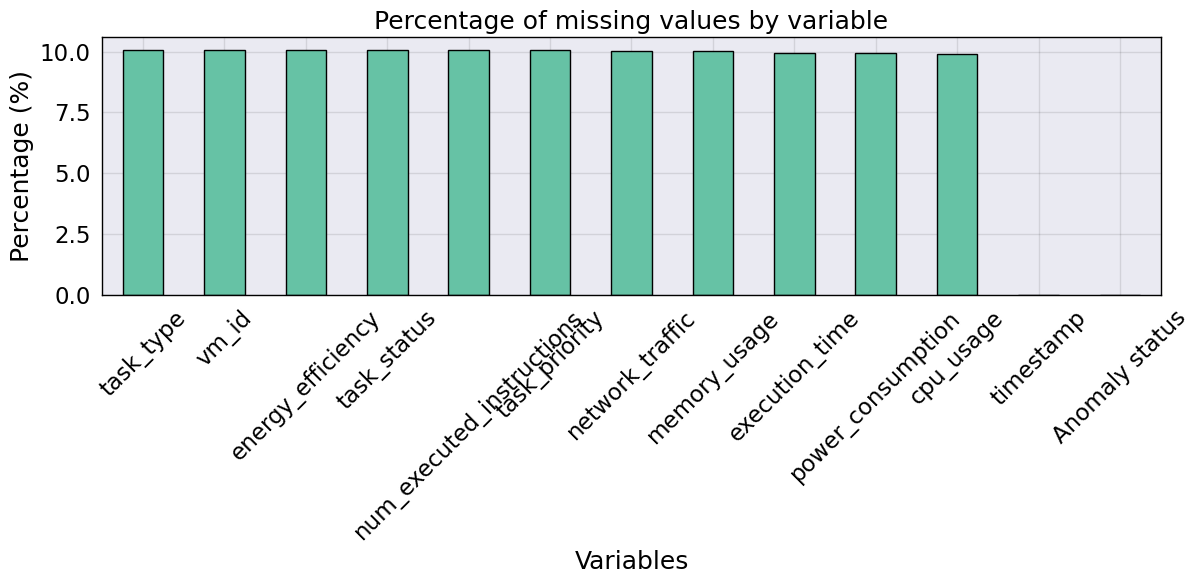

In [10]:
# For total missing values
missing_total = df.isnull().sum()
non_missing_total = df.notnull().sum()
total_values = len(df)

missing_percent = (missing_total / total_values) * 100

missing_df = pd.DataFrame({
    'Missing values': missing_total,
    'Non-missing values': non_missing_total,
    'Total records': total_values,
    'Missing percentage (%)': missing_percent
}).sort_values(by='Missing values', ascending=False)

print("\nGlobal summary of missing values by variable:\n")
try:
    print(missing_df.to_markdown(tablefmt="github", floatfmt=".2f"))
except:
    print(missing_df.to_string(float_format="%.2f"))

missing_df[['Non-missing values', 'Missing values']].plot(
    kind='bar', stacked=True, figsize=(14, 6),
)
plt.title("Global distribution of missing and non-missing values by variable")
plt.xlabel("Variables")
plt.ylabel("Number of records")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
missing_df['Missing percentage (%)'].plot(kind='bar')
plt.title("Percentage of missing values by variable")
plt.ylabel("Percentage (%)")
plt.xlabel("Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Correlation Analysis on the Raw Dataset

Correlations with 'Anomaly status':
Anomaly status               1.000000
network_traffic              0.040148
cpu_usage                    0.001908
num_executed_instructions    0.001474
power_consumption            0.000087
execution_time              -0.001197
memory_usage                -0.003578
energy_efficiency           -0.217539
Name: Anomaly status, dtype: float64


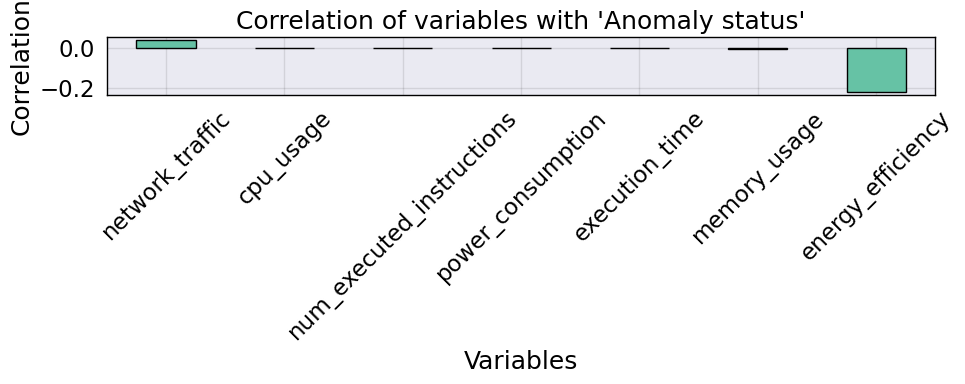

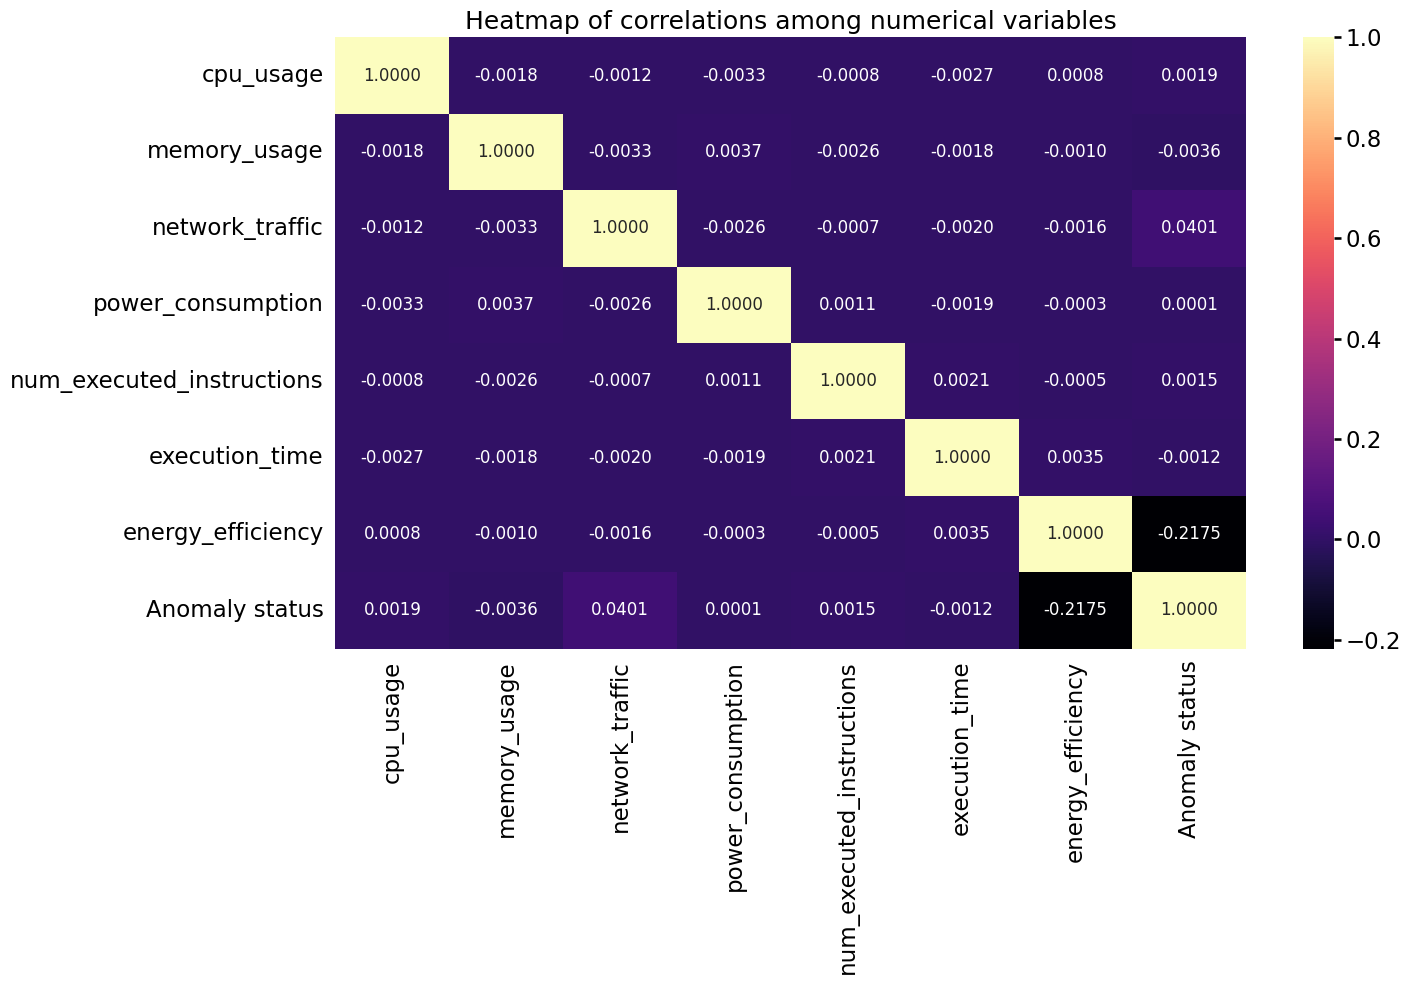

In [11]:
numerical_predictors = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[numerical_predictors].corr()

print("Correlations with 'Anomaly status':")
corr_with_target = corr_matrix['Anomaly status'].sort_values(ascending=False)
print(corr_with_target)

# Correlation with the target variable
plt.figure(figsize=(10, 4))
corr_with_target.drop('Anomaly status').plot(kind='bar')
plt.title("Correlation of variables with 'Anomaly status'")
plt.ylabel("Correlation")
plt.xlabel("Variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", linewidths=0, cmap='magma')
plt.title("Heatmap of correlations among numerical variables")
plt.tight_layout()
plt.show()


From this correlation analysis, it can be observed that `Anomaly status` exhibits very weak relationships with most system variables, such as `cpu_usage`, `num_executed_instructions`, `power_consumption`, `execution_time`, and `memory_usage`, suggesting that none of them have a strong linear association with the presence of anomalies.

The most notable exception is `energy_efficiency`, which shows a moderate negative correlation (–0.217), indicating that lower energy efficiency is associated with a higher likelihood of anomalies, and possibly `network_traffic` to a lesser extent.


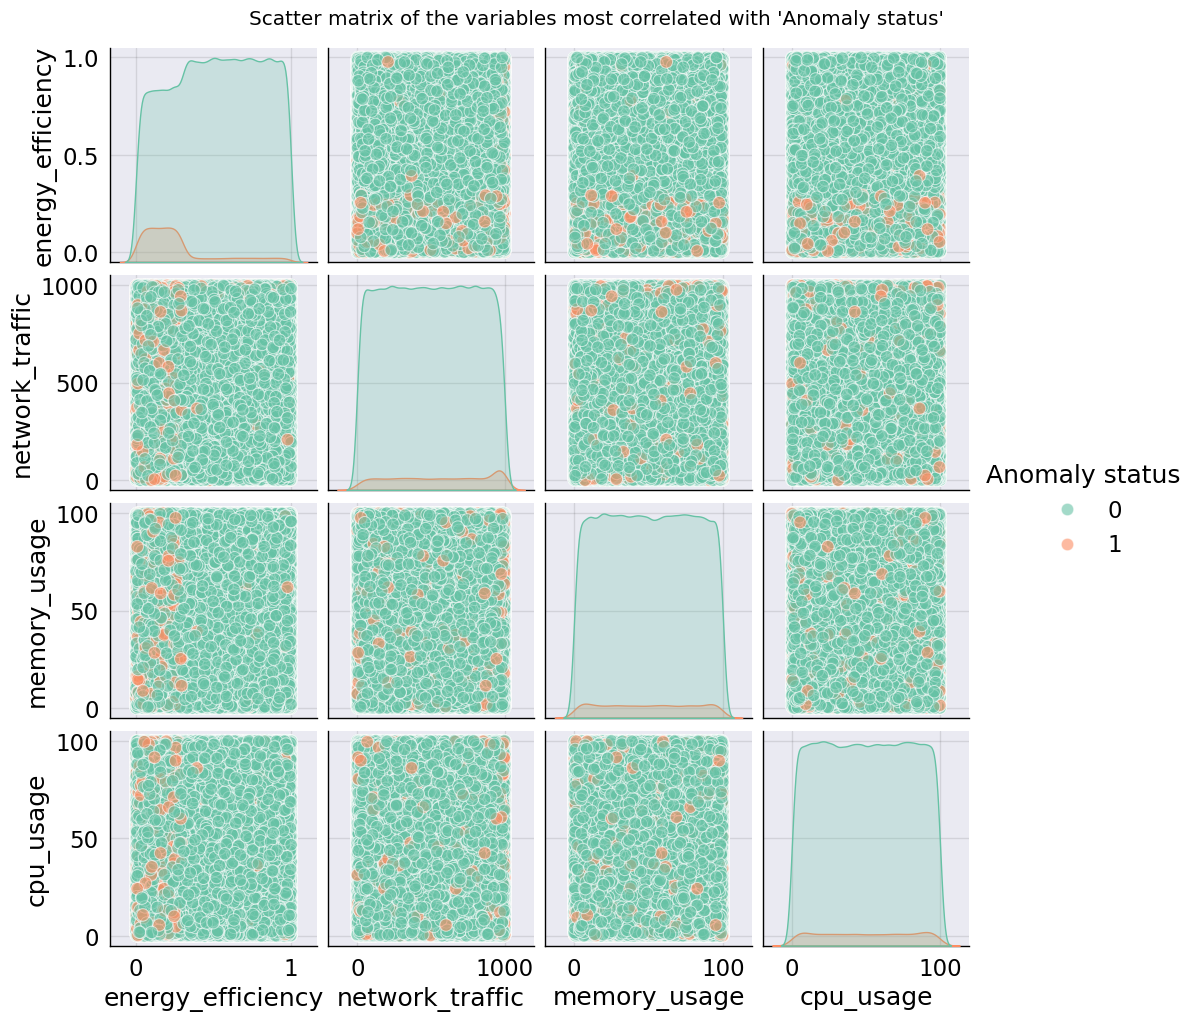

In [12]:
# Scatter matrix of the most correlated variables
top_corr = corr_with_target.abs().sort_values(ascending=False)[1:5].index  # 4 variables most correlated with the class
sns.pairplot(
    df,
    vars=top_corr,
    hue='Anomaly status',
    palette='Set2',
    plot_kws={'alpha': 0.6}
)
plt.suptitle(
    "Scatter matrix of the variables most correlated with 'Anomaly status'",
    y=1.02
)
plt.show()


In this scatter matrix, constructed from the imbalanced dataset, normal and anomalous records appear completely mixed, with no clear linear separation or evident clustering. This suggests that no single variable—such as `cpu_usage`, `memory_usage`, `network_traffic`, or `energy_efficiency`—is sufficient on its own to distinguish anomalous behavior, as anomalies are spread across the entire range of values.



To better visualize potential patterns, we arbitrarily created a balanced dataset with 60 samples from each class.


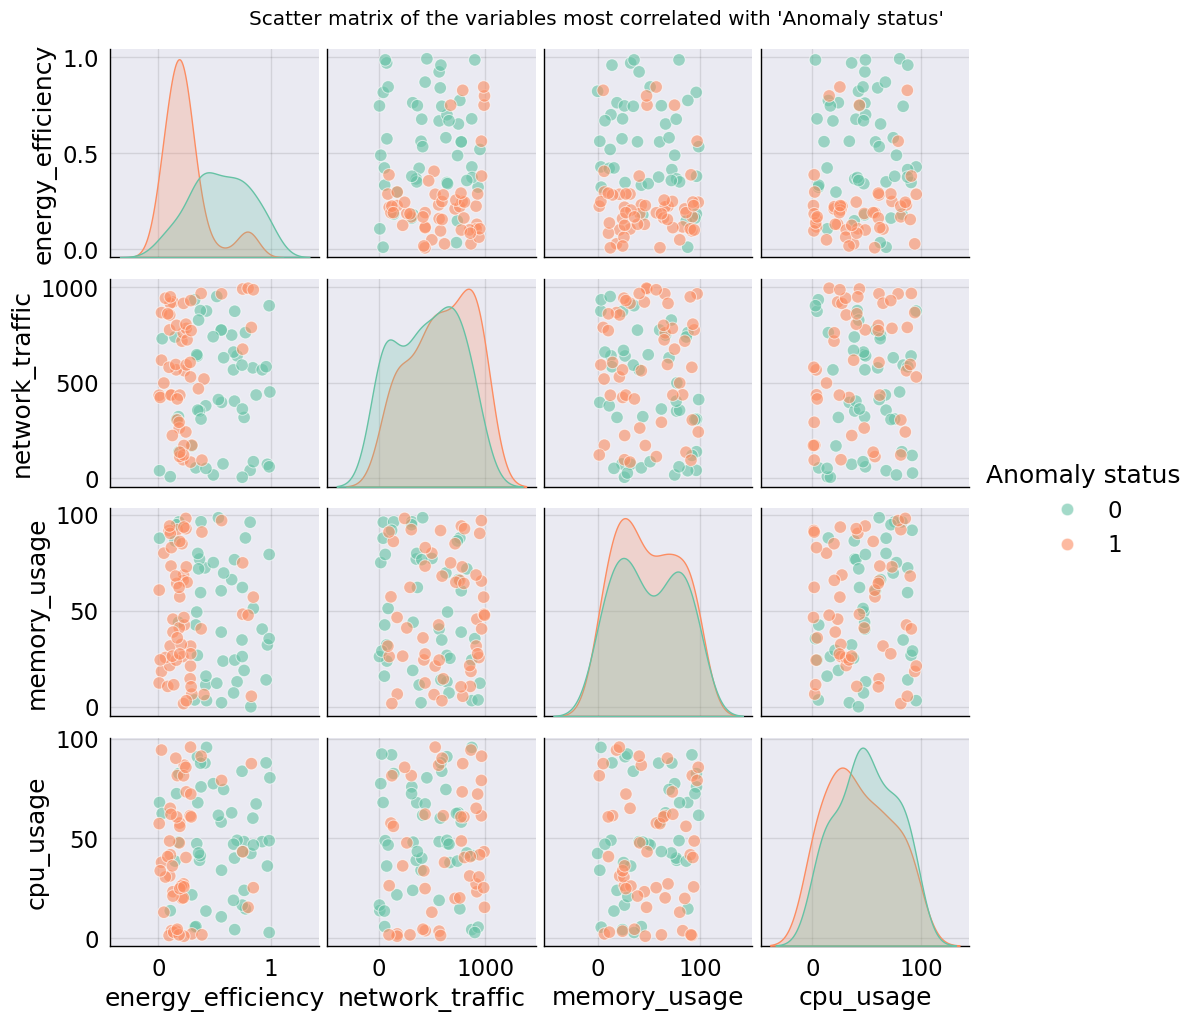

In [13]:
numerical_predictors = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
corr_matrix = df[numerical_predictors].corr()
corr_with_target = corr_matrix['Anomaly status'].sort_values(ascending=False)

df_0 = df[df['Anomaly status'] == 0]
df_1 = df[df['Anomaly status'] == 1]

# Select 60 records from each class
df_0_sample = df_0.sample(n=60, random_state=42)
df_1_sample = df_1.sample(n=60, random_state=42)

# Adjusted dataset for better visualization
df_balanced = pd.concat([df_0_sample, df_1_sample], axis=0).reset_index(drop=True)

top_corr = corr_with_target.abs().sort_values(ascending=False)[1:5].index  # 4 variables most correlated with the class

sns.pairplot(
    df_balanced,
    vars=top_corr,
    hue='Anomaly status',
    palette='Set2',
    plot_kws={'alpha': 0.6}
)

plt.suptitle(
    "Scatter matrix of the variables most correlated with 'Anomaly status'",
    y=1.02
)
plt.show()


Reducing the dataset enabled the visualization of patterns. 

This analysis reveals that `energy_efficiency` has the strongest discriminative potential, as anomalous samples tend to concentrate at lower values while normal samples mainly occupy mid-range values. `network_traffic` also shows slight differences, with normal instances skewed toward higher values and anomalous ones more concentrated at mid-to-low ranges. In contrast, `cpu_usage` and `memory_usage` exhibit almost complete overlap between classes, confirming their low individual predictive power.


# 2 Data Preparation


To prepare the data analyzed in the previous section, and based on the inspection and exploration performed—where several issues, characteristics, and potential actions were identified—we define the following workflow to obtain a dataset suitable for training and evaluating supervised machine learning models:

1. Identify and remove irrelevant columns  
2. Remove rows with excessive missing values  
3. Impute missing values  
4. Encode categorical variables  
5. Scale numerical variables  
6. Balance the dataset  
7. Perform feature selection


In [14]:
prepared_df = df.copy()

## Identifying and Handling Irrelevant Columns

The `vm_id` column represents a unique identifier assigned to each virtual machine. Variables of this type are typically created for administrative purposes rather than to describe system behavior or performance characteristics.


Unique values in vm_id: 249595
Total rows: 277570
count    249595.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: count, dtype: float64


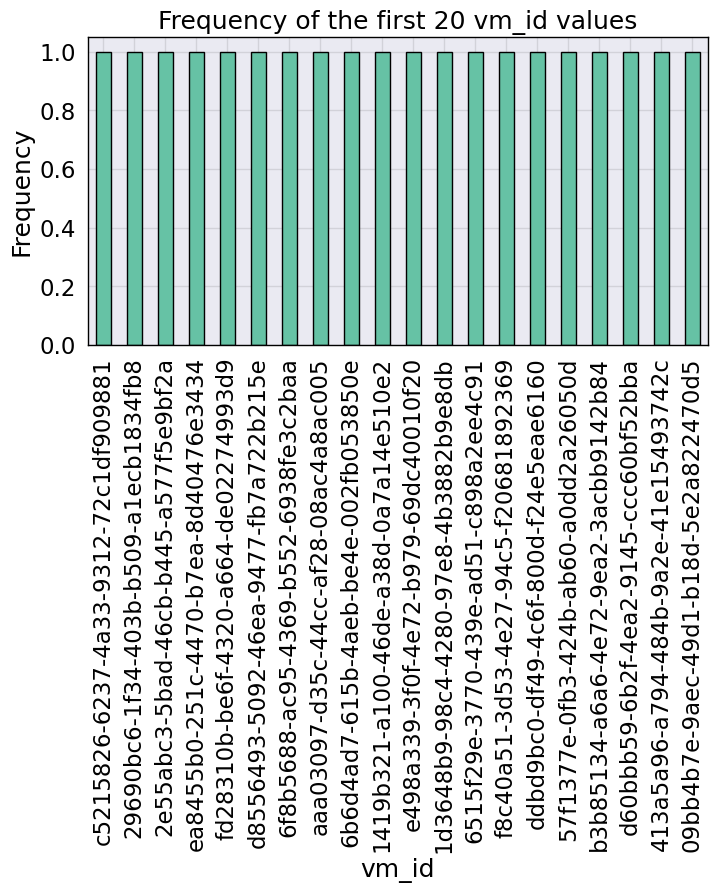

In [15]:
# Uniqueness analysis of vm_id
unique_ids = df["vm_id"].nunique()
total_rows = len(df)

print("Unique values in vm_id:", unique_ids)
print("Total rows:", total_rows)

# Frequency distribution
id_counts = df["vm_id"].value_counts()
print(id_counts.describe())

plt.figure(figsize=(8, 4))
id_counts.head(20).plot(kind="bar")
plt.title("Frequency of the first 20 vm_id values")
plt.xlabel("vm_id")
plt.ylabel("Frequency")
plt.show()


Here, we observe that the `vm_id` variable contains a unique value for each record. Even when considering the missing values identified during the initial inspection, the frequency histogram shows no repetitions or patterns that could be associated with the target variable `Anomaly status`. This indicates that `vm_id` does not provide predictive information, lacks useful variability, shows no meaningful correlation with numerical or categorical variables, and may introduce noise and overfitting in models sensitive to high dimensionality. Therefore, its removal from the dataset is justified.


In [16]:
# Remove the vm_id column
prepared_df.drop(['vm_id'], axis=1, inplace=True)


The `timestamp` variable represents the date and time at which each record was captured. In some contexts, temporal features may be directly related to the occurrence of anomalies. Therefore, before removing this variable, it is necessary to evaluate whether any significant temporal patterns influence the target variable.


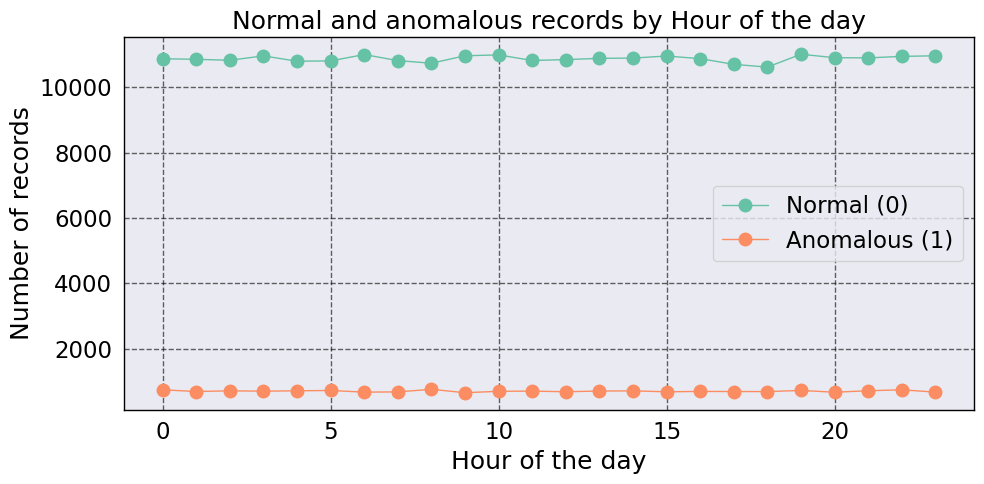

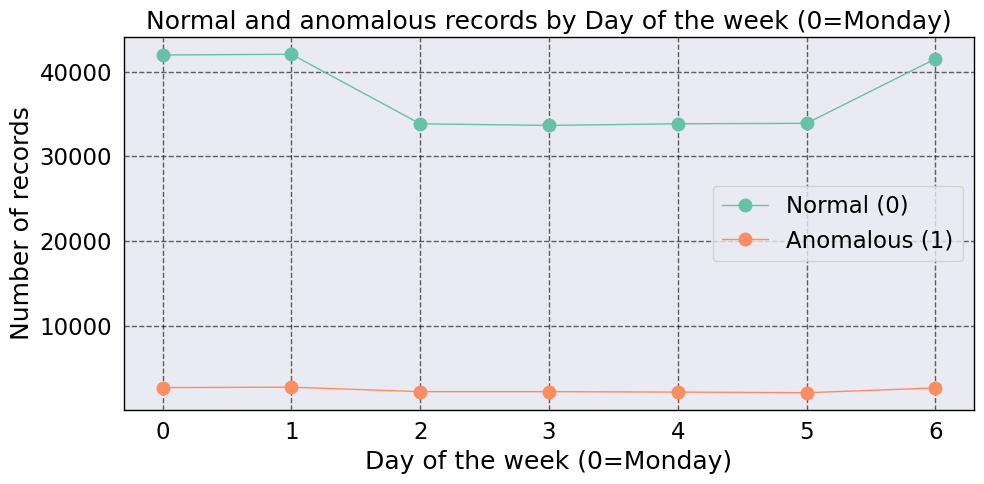

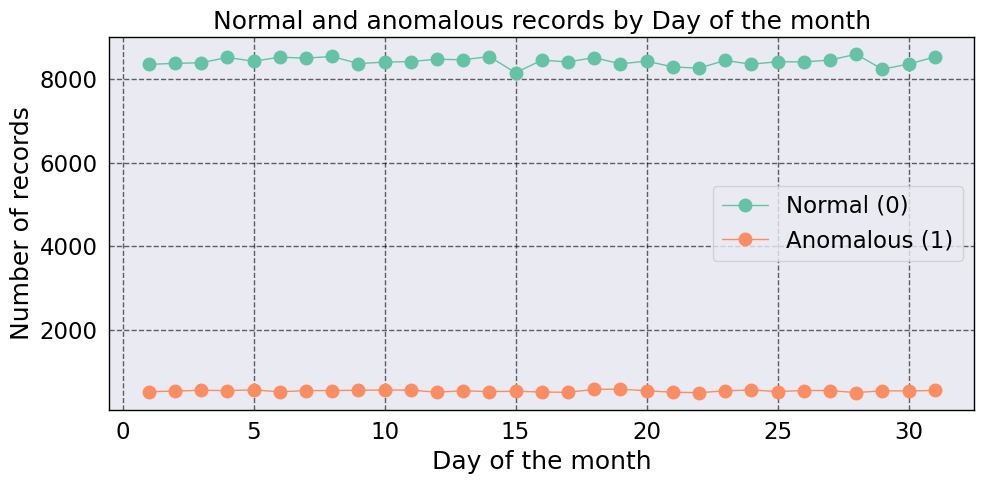

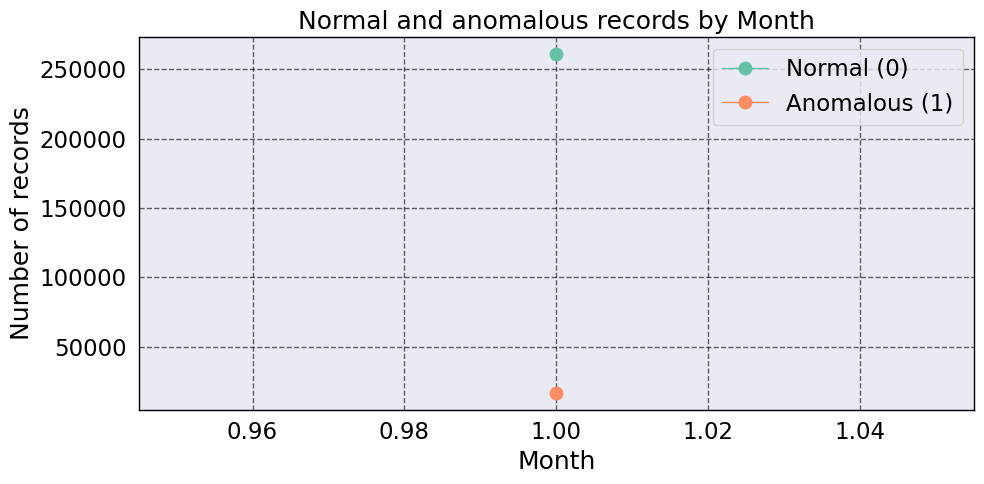

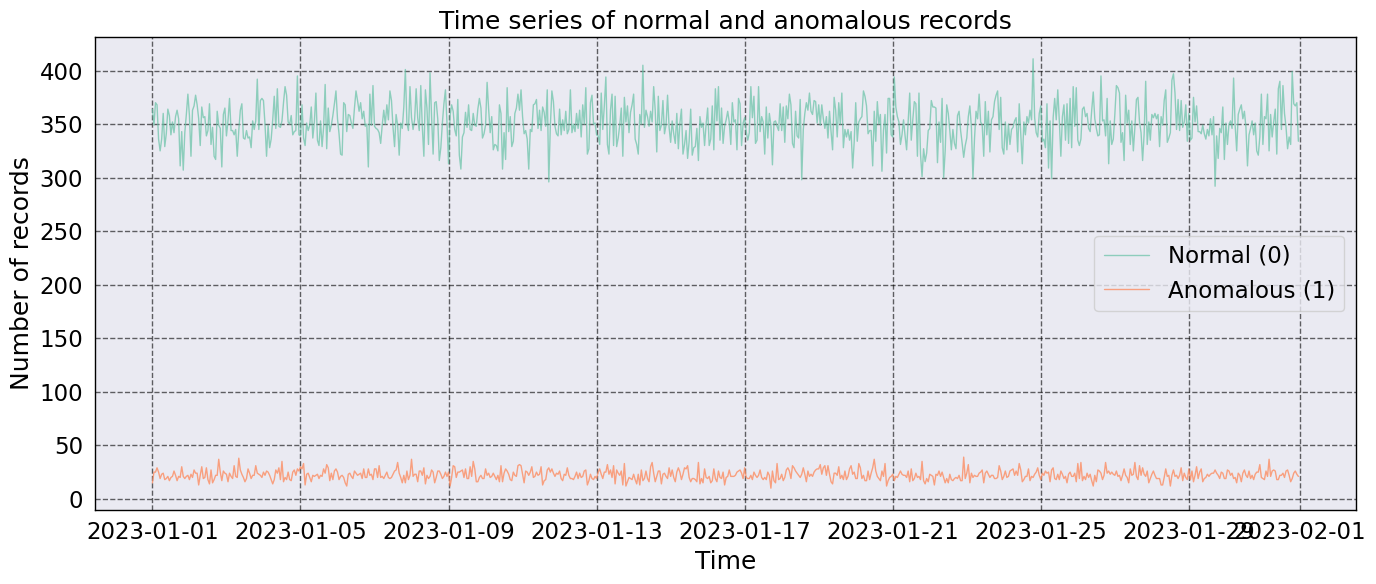

In [17]:
# Convert timestamp to datetime
prepared_df['timestamp'] = pd.to_datetime(
    prepared_df['timestamp'],
    format='%d-%m-%Y %H:%M'
)

# Create time-based features
prepared_df['hour'] = prepared_df['timestamp'].dt.hour
prepared_df['dayofweek'] = prepared_df['timestamp'].dt.dayofweek   # 0 = Monday, 6 = Sunday
prepared_df['day'] = prepared_df['timestamp'].dt.day
prepared_df['month'] = prepared_df['timestamp'].dt.month

def plot_by_anomaly(prepared_df, time_col, title):
    plt.figure(figsize=(10, 5))

    # Group by temporal value
    grouped = prepared_df.groupby(time_col)['Anomaly status']

    # Normal series
    normal = grouped.apply(lambda x: (x == 0).sum())

    # Anomalous series
    anomalous = grouped.apply(lambda x: (x == 1).sum())

    # Plot
    plt.plot(normal.index, normal.values, marker='o', linestyle='-', label='Normal (0)')
    plt.plot(anomalous.index, anomalous.values, marker='o', linestyle='-', label='Anomalous (1)')

    plt.title(f'Normal and anomalous records by {title}')
    plt.xlabel(title)
    plt.ylabel('Number of records')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_by_anomaly(prepared_df, 'hour', 'Hour of the day')
plot_by_anomaly(prepared_df, 'dayofweek', 'Day of the week (0=Monday)')
plot_by_anomaly(prepared_df, 'day', 'Day of the month')
plot_by_anomaly(prepared_df, 'month', 'Month')

# Group by hour
prepared_df_time = prepared_df.set_index('timestamp')

# Count normal (0) and anomalous (1) records per hour
normal_series = prepared_df_time[
    prepared_df_time['Anomaly status'] == 0
].resample('h').size()

anomaly_series = prepared_df_time[
    prepared_df_time['Anomaly status'] == 1
].resample('h').size()

plt.figure(figsize=(14, 6))
plt.plot(normal_series.index, normal_series.values, label='Normal (0)', alpha=0.7)
plt.plot(anomaly_series.index, anomaly_series.values, label='Anomalous (1)', alpha=0.8)

plt.title('Time series of normal and anomalous records')
plt.xlabel('Time')
plt.ylabel('Number of records')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


After converting and analyzing the temporal variable, no relevant patterns were identified between the date or time and the occurrence of anomalies. The distributions by hour, day, and month are similar for both classes, and the visualizations do not reveal clear trends. This indicates that temporal features do not explain the variability of the target class, provide no meaningful information for classification, and would only add unnecessary noise and dimensionality. Therefore, removing the `timestamp` variable is justified.


In [18]:
# Remove time-based columns
prepared_df.drop(
    ['timestamp', 'hour', 'dayofweek', 'day', 'month'],
    axis=1,
    inplace=True
)


## Removing Rows with Excessive Missing Values

Given this strong imbalance, aggressively removing records from the minority anomalous class would further reduce its representation and negatively impact the model’s ability to learn rare patterns. Therefore, an asymmetric data cleaning strategy was adopted:

- Apply a row-removal threshold **only to class 0**, removing records that exceed a predefined number of missing values.
- Fully preserve **class 1**, imputing its missing values to maintain its original distribution and learning fidelity, while slightly reducing the imbalance.

The following code quantifies the impact of this decision on class 0 using a removal threshold of more than two missing values per record.


In [19]:
UMBRAL_ELIMINACION = 2

# Identify rows belonging to class 0
clase_0 = prepared_df['Anomaly status'] == 0

# Condition: more than UMBRAL_ELIMINACION missing values
condicional = prepared_df.isna().sum(axis=1) > UMBRAL_ELIMINACION

# Count for reporting
total_clase_0 = clase_0.sum()
conteo_condicional = (clase_0 & condicional).sum()

if total_clase_0 > 0:
    porcentaje = (conteo_condicional / total_clase_0) * 100
    print(f"Total records in Class 0: {total_clase_0}")
    print(f"Class 0 records with more than {UMBRAL_ELIMINACION} NaNs (to be removed): {conteo_condicional}")
    print(f"Percentage of Class 0 records to be removed: {porcentaje:.2f}%")
else:
    print("There are no records in Class 0 to calculate the percentage.")

# Remove rows in Class 0 that exceed the threshold
prepared_df = prepared_df.drop(
    prepared_df[clase_0 & condicional].index
).reset_index(drop=True)

print("Final dataframe shape:", prepared_df.shape)


Total records in Class 0: 260916
Class 0 records with more than 2 NaNs (to be removed): 18502
Percentage of Class 0 records to be removed: 7.09%
Final dataframe shape: (259068, 11)


## Imputing Missing Values

Accordingly, the `SimpleImputer(strategy="mean")` method is applied to the general numerical variables.


In [ ]:
# List of general numerical variables
vars_num_general = [
    "cpu_usage", "memory_usage", "network_traffic",
    "power_consumption", "energy_efficiency"
]

# Impute missing values using the mean strategy
imputer_mean = SimpleImputer(strategy="mean")
prepared_df[vars_num_general] = imputer_mean.fit_transform(
    prepared_df[vars_num_general]
)

Although most numerical variables show uniform distributions, some—such as `num_executed_instructions` and `execution_time`—lack a clearly bounded range. For these variables, preserving local relationships is preferable.

Therefore, a KNN-based imputation strategy is applied, using already imputed numerical variables as contextual input to estimate missing values based on similarity in the feature space.


In [22]:
# Context-related numerical variables
vars_context = [
    "cpu_usage", "memory_usage", "network_traffic",
    "power_consumption", "energy_efficiency",
    "num_executed_instructions", "execution_time"
]

# Impute missing values using KNN-based imputation
imputer_knn = KNNImputer(n_neighbors=5, weights="uniform")
prepared_df[vars_context] = imputer_knn.fit_transform(
    prepared_df[vars_context]
)

Categorical variables such as `task_type` and `task_status` do not exhibit extreme category dominance, and the dataset appears to have been generated with broad coverage of possible states. As an initial approach, mode-based imputation (`most_frequent`) is adopted, as it provides valid and reproducible values.


In [23]:
vars = ["task_type", "task_status"]
imputer_mode = SimpleImputer(strategy="most_frequent")
prepared_df[vars] = imputer_mode.fit_transform(prepared_df[vars])

The `task_priority` variable is ordinal, with an inherent order (e.g., low < medium < high). To preserve this hierarchy, a KNN-based imputation strategy is applied on an ordinal encoding.

The procedure involves ordinally encoding the variable, applying `KNNImputer` using the already imputed numerical variables as context, rounding the predictions to valid ordinal levels, and finally decoding the values back to their original categorical labels.


In [24]:
# Initialize ordinal encoder for task priority
encoder_priority = OrdinalEncoder()

# Fit the encoder only on non-null task_priority values
non_null_priority = (
    prepared_df[prepared_df["task_priority"].notna()]["task_priority"]
    .values.reshape(-1, 1)
)
encoder_priority.fit(non_null_priority)

# Create forward and inverse mappings for categories
mapping = {cat: idx for idx, cat in enumerate(encoder_priority.categories_[0])}
inv_mapping = {v: k for k, v in mapping.items()}

# Map categorical task_priority to ordinal values
prepared_df["task_priority_ord"] = prepared_df["task_priority"].map(mapping)

# KNN imputation including the ordinal priority variable
imputer_knn_ord = KNNImputer(n_neighbors=5)
cols_for_knn_ord = [
    "cpu_usage", "memory_usage", "network_traffic",
    "power_consumption", "energy_efficiency", "task_priority_ord"
]
knn_result = imputer_knn_ord.fit_transform(prepared_df[cols_for_knn_ord])

# Extract and round the imputed ordinal priority values
task_priority_imputed = np.rint(knn_result[:, -1]).astype(int)

# Ensure imputed values stay within valid category bounds
min_cat = 0
max_cat = len(encoder_priority.categories_[0]) - 1
task_priority_imputed = np.clip(task_priority_imputed, min_cat, max_cat)

# Map ordinal values back to original categorical labels
prepared_df["task_priority"] = [inv_mapping[val] for val in task_priority_imputed]

# Drop the auxiliary ordinal column
prepared_df.drop(columns=["task_priority_ord"], inplace=True)

We verify that no missing values remain:


In [25]:
print("NaNs per column after imputation:")
print(prepared_df.isna().sum())

NaNs per column after imputation:
cpu_usage                    0
memory_usage                 0
network_traffic              0
power_consumption            0
num_executed_instructions    0
execution_time               0
energy_efficiency            0
task_type                    0
task_priority                0
task_status                  0
Anomaly status               0
dtype: int64


**3.4. Encoding Categorical Variables**

At this stage of preprocessing, categorical variables are transformed so they can be interpreted by supervised learning models. Since the `vm_id` and `timestamp` columns were previously removed due to their lack of predictive value, the focus is placed on the remaining categorical variables: `task_type`, `task_priority`, and `task_status`. Each of these variables has different characteristics, making it important to apply an encoding method appropriate to its nature.

Before transformation, it is necessary to determine whether the information represents nominal categories or categories with an inherent order. Nominal variables have no hierarchical relationship between categories, whereas ordinal variables reflect an implicit ranking and therefore require encoding techniques that preserve this order.
